In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)

import shap
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load data
df = pd.read_csv("diabetes.csv")

# Replace invalid 0s with NaNs in relevant columns
invalid_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[invalid_cols] = df[invalid_cols].replace(0, np.nan)

# Fill missing values with column medians
df.fillna(df.median(numeric_only=True), inplace=True)

# Split features and target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate models
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "Model": model
    }

# Print metrics
for name, res in results.items():
    print(f"\n{name} Results:")
    for metric, val in res.items():
        if metric not in ["Confusion Matrix", "Model"]:
            print(f"{metric}: {val:.4f}")
    print("Confusion Matrix:\n", res["Confusion Matrix"])



Logistic Regression Results:
Accuracy: 0.7532
Precision: 0.6667
Recall: 0.6182
F1 Score: 0.6415
ROC AUC: 0.8228
Confusion Matrix:
 [[82 17]
 [21 34]]

Random Forest Results:
Accuracy: 0.7338
Precision: 0.6250
Recall: 0.6364
F1 Score: 0.6306
ROC AUC: 0.8341
Confusion Matrix:
 [[78 21]
 [20 35]]

XGBoost Results:
Accuracy: 0.7143
Precision: 0.5873
Recall: 0.6727
F1 Score: 0.6271
ROC AUC: 0.7774
Confusion Matrix:
 [[73 26]
 [18 37]]


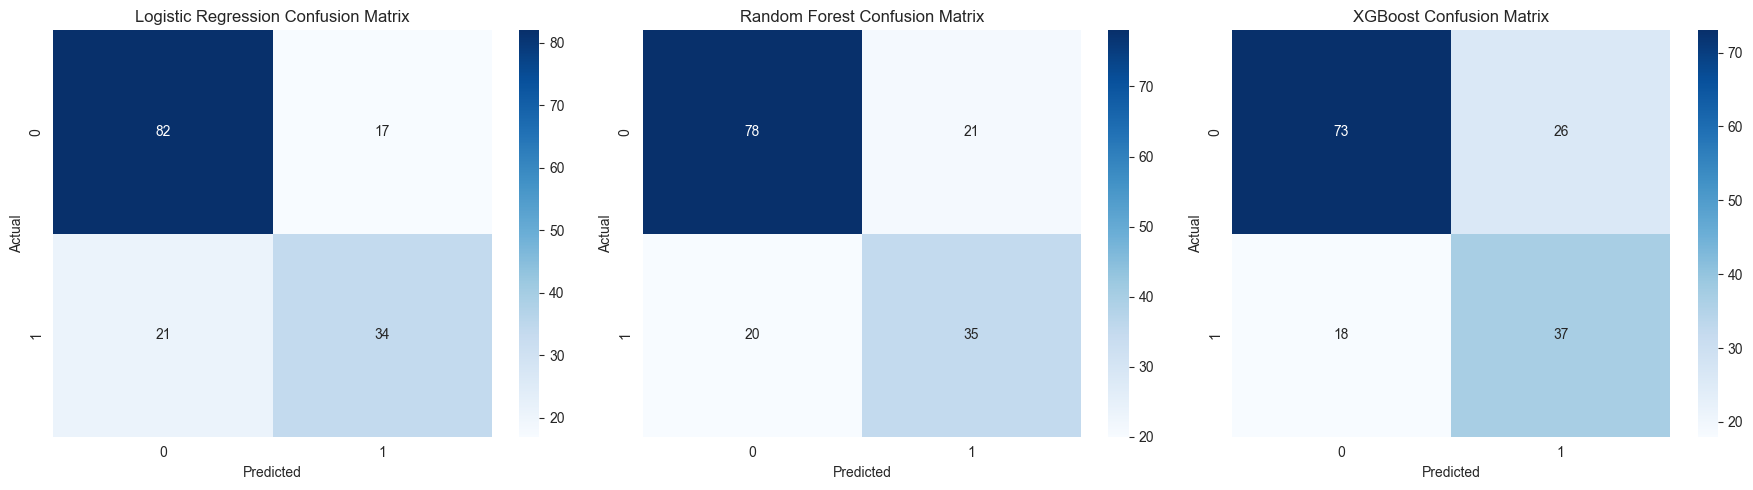

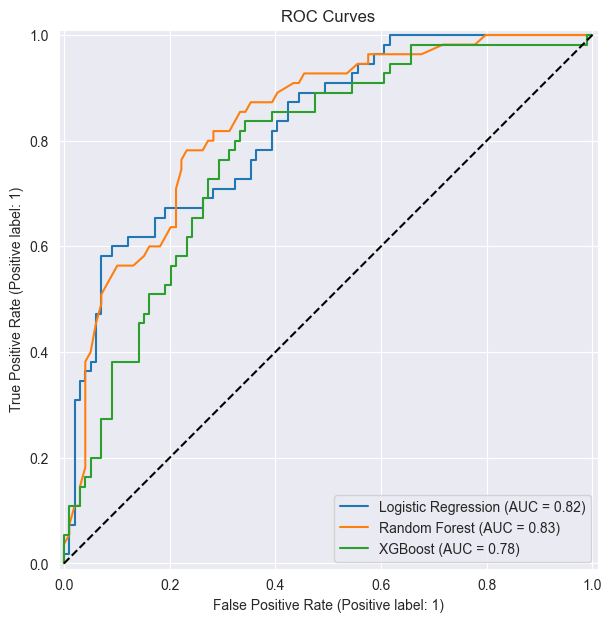

In [4]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, res) in zip(axes, results.items()):
    sns.heatmap(res["Confusion Matrix"], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curves
plt.figure(figsize=(10, 7))
for name, res in results.items():
    RocCurveDisplay.from_estimator(res["Model"], X_test_scaled, y_test, name=name, ax=plt.gca())
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.grid(True)
plt.show()


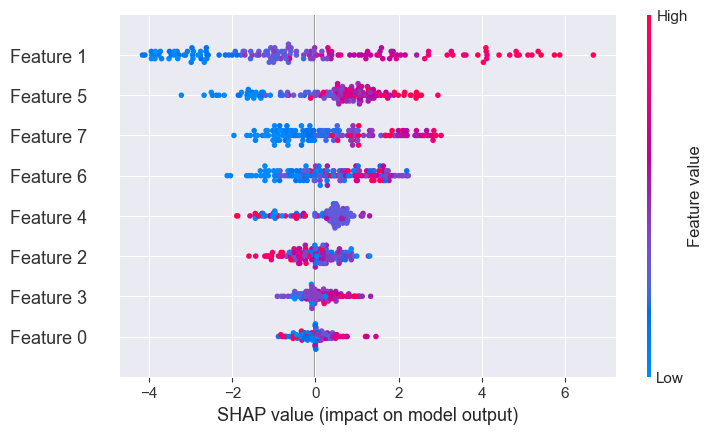

In [5]:
# SHAP values for XGBoost
best_model = results["XGBoost"]["Model"]
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# SHAP summary plot
shap.plots.beeswarm(shap_values)


In [6]:
import pickle
pickle.dump(best_model, open("xgb_model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))
